In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform
# from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [3]:
from utils_cluster import genNormalizedX
from utils_plot import clsInspection

In [4]:
from fastdtw import fastdtw as fastdtw

In [5]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'Synthetic_crash_scenarios.csv'
# file_path = '/content/drive/MyDrive/Colab Notebooks/Thesis Crash Generation/New dataset/Synthetic_crash_scenarios.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Load the Data

In [6]:
V_l = np.zeros((5000,97))
V_f = np.zeros((5000,97))
D = np.zeros((5000,97))
Weight = np.zeros(5000)
for i in range(1,5001):
    v_l_i = df[df["id"]==i].iloc[-98:-1, 3].to_numpy()
    v_f_i = df[df["id"]==i].iloc[-98:-1, 2].to_numpy()
    d_i = df[df["id"]==i].iloc[-98:-1, 4].to_numpy() - df[df["id"]==i].iloc[-2, 4]
    weight_i = df[df["id"]==i].iloc[0, 6]
    V_l[i-1,:], V_f[i-1,:], D[i-1,:] = v_l_i, v_f_i, d_i
    Weight[i-1] = weight_i

V_l_raw = copy.deepcopy(V_l)
V_f_raw = copy.deepcopy(V_f)
D_raw = copy.deepcopy(D)
Weight_raw = copy.deepcopy(Weight)

In [7]:
V_l = copy.deepcopy(V_l_raw)
V_f = copy.deepcopy(V_f_raw)
D = copy.deepcopy(D_raw)
A_l = np.gradient(V_l, axis=1)/0.05
A_f = np.gradient(V_f, axis=1)/0.05
Weight = copy.deepcopy(Weight_raw)

# X = genNormalizedX(V_l,V_f,D,A_l,A_f)
X = genNormalizedX(V_l,V_f,D)

# Clustering

In [8]:
def hc_dm(X, alg="euclidean"):
    '''
    Calculate the distance matrix for H Clustering
    '''
    if alg == 'euclidean':
        dist_matrix = pdist(X)
    elif alg == 'dtw':
        dist_matrix = pdist(X, lambda u, v: fastdtw(u, v)[0])
    else:
        raise ValueError("Invalid algorithm. Please choose 'euclidean' or 'dtw'.")
    return dist_matrix

def hc_fcluster(dist_matrix, method='single', n_cls=16, figsize=(10, 8)):
    '''
    inputs: distance matrix
    output: cluster label
    '''
    ## form linkage
    Z = linkage(dist_matrix, method=method)
    ## assign labels
    y = fcluster(Z, t=n_cls, criterion='maxclust')
    ## plot dendrogram
    if figsize is not None:
        plt.figure(figsize=figsize)
        dendrogram(Z, truncate_mode='lastp', p=n_cls)
        plt.show()
    return y

In [9]:
def hc_secondary(dist_matrix,y,y_target,n_target,filter_threshold=None,method='single',figsize=(4,3.2)):
    '''
    dist_matrix: raw dm
    y: cluster labels
    y_target: the cluster label that we want to do secondary clustering
    n_target: number of clusters for secondary clustering
    '''
    ## extract distance matrix for
    dm_squareform = squareform(dist_matrix)
    dm_sec = dm_squareform[y==y_target][:,y==y_target]
    dm_sec = squareform(dm_sec)

    y_updated = np.copy(y)
    if figsize is None:
        y_sec = hc_fcluster(dm_sec, method=method, n_cls=n_target, figsize=None)
    else:
        y_sec = hc_fcluster(dm_sec, method=method, n_cls=n_target, figsize=figsize)
    if filter_threshold is not None:
        y_sec = filterOutlier(y_sec,threshold=filter_threshold)
    y_updated[y_updated==y_target] += y_sec
    return y_updated

In [10]:
def filterOutlier(y,threshold=2):
    '''
    threshold: number of minimum samples in a cluster
    '''
    y_updated = np.copy(y)
    labels, numbers = np.unique(y,return_counts=True)
    for i, label in enumerate(labels):
        if numbers[i]<threshold:
            y_updated[y==label] = 0
    return y_updated

In [11]:
def mergeOutlierToOther(dist_matrix,y,y_target):
    dm_sqr = squareform(dist_matrix)
    dm_sqr_target = dm_sqr[y==y_target]
    labels = np.unique(y)
    min_dist = np.zeros((dm_sqr_target.shape[0],labels.shape[0]))
    for i_label, label in enumerate(labels):
        min_dist[:,i_label] = np.min(dm_sqr_target[:,y==label],axis=1)
    y[y==y_target] = labels[labels!=y_target][np.argmin(min_dist[:,labels!=y_target],axis=1)]

First Clustering

In [12]:
# dist_matrix = pdist(X[:,:,1], lambda u, v: fastdtw(u, v)[0])
# np.save('hc_dm.npy', dist_matrix)

In [13]:
dist_matrix = np.load('.\\utils_data\\hc_dm.npy')

In [14]:
n_clusters = 12
y = hc_fcluster(dist_matrix, method='single', n_cls=n_clusters, figsize=None)
y = filterOutlier(y)

Second Clustering

In [15]:
y_updated = y*100
## Cluster 2
y_updated = hc_secondary(dist_matrix,y_updated,y_target=2*100,n_target=2,filter_threshold=None,method='single',figsize=None)
## Cluster 3
y_updated = hc_secondary(dist_matrix,y_updated,y_target=3*100,n_target=38,filter_threshold=None,method='single',figsize=None)
y_updated = filterOutlier(y_updated,threshold=10)
## Cluster 5
y_updated = hc_secondary(dist_matrix,y_updated,y_target=5*100,n_target=2,filter_threshold=None,method='single',figsize=None)
## Cluster 6
y_updated = hc_secondary(dist_matrix,y_updated,y_target=6*100,n_target=70,filter_threshold=None,method='single',figsize=None)
y_updated = filterOutlier(y_updated,threshold=10)
## Cluster 6.9
y_updated = y_updated*100
y_updated = hc_secondary(dist_matrix,y_updated,y_target=609*100,n_target=4,filter_threshold=None,method='complete',figsize=None)
## Cluster 6.18
y_updated = hc_secondary(dist_matrix,y_updated,y_target=618*100,n_target=5,filter_threshold=None,method='complete',figsize=None)
## Cluster 6.38
y_updated = hc_secondary(dist_matrix,y_updated,y_target=638*100,n_target=3,filter_threshold=None,method='complete',figsize=None)

mergeOutlierToOther(dist_matrix,y_updated,y_target=0)

In [16]:
np.save('.\\utils_data\\hc_y.npy', y_updated)

In [16]:
np.unique(y_updated,return_counts=True)

(array([    0, 10000, 20100, 20200, 31800, 31900, 32100, 40000, 50100,
        50200, 60901, 60902, 60903, 60904, 61801, 61802, 61803, 61804,
        61805, 63801, 63802, 63803]),
 array([ 142,  873,   52,  242,   44,  237,   77,   11,   46,  108,   30,
         318,   71,  105,   28,   69,   66,   15,   26, 1039, 1043,  358],
       dtype=int64))

In [17]:
# array([ 142,  873,   52,  242,   44,  237,   77,   11,   46,  108,   30,
#          318,  71,  105,   28,   69,   66,   15,   26, 1039, 1043,  358],
# array([       873,   52,  242,   69,  244,   94,   11,   46,  110,   41, 
#          319,  71,  108,   45,   72,   75,   18,   27, 1055, 1054,  374],

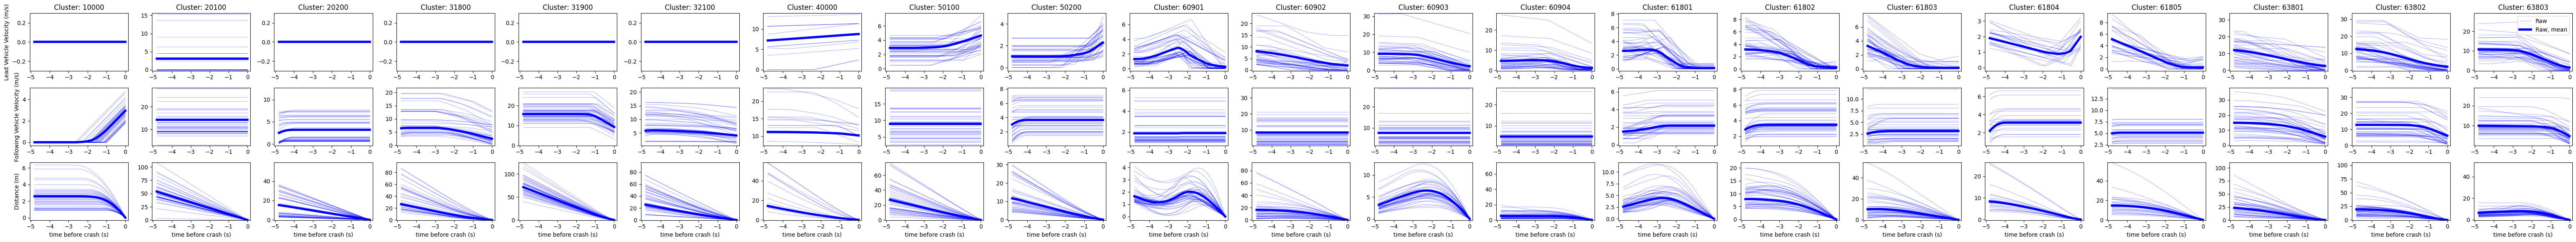

In [18]:
clsInspection(
    X,
    y_updated,
    Weight,
    dimen=3,
#     cluster_selection = list(np.unique(y_updated)[1:]),
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

# Distribution Check

## split dataset

In [19]:
def split_based_on_labels(y,weights,split_size = 0.5):
    idxes_splited = []
    labels = np.unique(y)
    for label in labels:
        times = 0
        # print(label)
        idxes_cls = np.arange(y.shape[0])[y==label]
        while True:
            times += 1
            # print(times)
            if times>10000:
                print(label)
                raise ValueError("couldn't split")
            # np.random.shuffle(idxes_cls)
            idxes_cls = np.random.permutation(idxes_cls)
            weights_cls = weights[idxes_cls]
            weights_cls_sum = np.sum(weights_cls)
            weights_cls_cumsum = np.cumsum(weights_cls)
            weights_cls_cumsum -= split_size*weights_cls_sum
            
            # Initialize variables to store the closest value and its index
            closest_index = 0
            closest_value = weights_cls_cumsum[0]
            # Iterate through the array to find the closest value to 0
            for i in range(1, len(weights_cls_cumsum)):
                if abs(weights_cls_cumsum[i]) < abs(closest_value):
                    closest_value = weights_cls_cumsum[i]
                    closest_index = i
                    
            ## if the weight value is within a threshold, store
            if abs(closest_value)<=1:
                idxes_cls_splited = idxes_cls[:closest_index+1]
                break
            elif label == 40000:
                if abs(closest_value)<=3:
                    idxes_cls_splited = idxes_cls[:closest_index+1]
                    print(idxes_cls_splited, idxes_cls[closest_index+1:])
                    break
#                 else:
#                     print(weights_cls_cumsum)
                
        idxes_splited.append(idxes_cls_splited)
        
    idxes_splited = np.array([item for sublist in idxes_splited for item in sublist])
    return idxes_splited

In [25]:
Idx_train = split_based_on_labels(y_updated, Weight, split_size = 0.5)
Idx_valtest = np.array([element for element in np.arange(y_updated.shape[0]) if element not in Idx_train])

[417] [2313  686 1230 1306 1837  518  764  716 1558 1396]


In [26]:
Idx_val = split_based_on_labels(y_updated[Idx_valtest], Weight[Idx_valtest], split_size = 0.5)
Idx_test = np.array([element for element in np.arange(Idx_valtest.shape[0]) if element not in Idx_val])
Idx_val = Idx_valtest[Idx_val]
Idx_test = Idx_valtest[Idx_test]

[336 261 378 662 734 580 866] [ 611 1080  353]


## check distribution

In [28]:
from utils_evaluation import weighted_ks_2samp

In [29]:
def mean_error_trainvaltest(kinematic, weight, Idx_train, Idx_val, Idx_test):
    mean_train = np.average(kinematic[Idx_train],axis = 0, weights=weight[Idx_train])
    mean_val = np.average(kinematic[Idx_val],axis = 0, weights=weight[Idx_val])
    mean_test = np.average(kinematic[Idx_test],axis = 0, weights=weight[Idx_test])

    error1 = np.linalg.norm(mean_train - mean_val)
    error2 = np.linalg.norm(mean_train - mean_test)
    error3 = np.linalg.norm(mean_val - mean_test)
    return error1, error2, error3, mean_train, mean_val, mean_test

def distribution_check(V_l, V_f, D, weight, Idx_train, Idx_val, Idx_test):
    Kine = [V_l[:,-1], V_f[:,-1] - V_l[:,-1], (V_l[:,-1] - V_l[:,-2])/0.05, (V_f[:,-1] - V_f[:,-2])/0.05, V_l[:,0], V_f[:,0], D[:,0]]
    for kine in Kine:
        ks_stat, ks_p = weighted_ks_2samp(kine[Idx_train],kine[Idx_val],weight[Idx_train],weight[Idx_val])
        if ks_p < 0.6:
            return False
        ks_stat, ks_p = weighted_ks_2samp(kine[Idx_train],kine[Idx_test],weight[Idx_train],weight[Idx_test])
        if ks_p < 0.6:
            return False
        ks_stat, ks_p = weighted_ks_2samp(kine[Idx_val],kine[Idx_test],weight[Idx_val],weight[Idx_test])
        if ks_p < 0.6:
            return False
  
    # Kine = [V_l, V_f, D]
    # for kine in Kine:
    #     error1, error2, error3, _, _, _ = mean_error_trainvaltest(kine, weight, Idx_train, Idx_val, Idx_test)
    #     if error1>5 or error2>5 or error3>20:
    #         return False
      
    return True

In [30]:
# np.intersect1d(np.where(y_updated==40000)[0], Idx_valtest)

In [31]:
Idx_train = split_based_on_labels(y_updated, Weight, split_size = 0.5)
Idx_valtest = np.array([element for element in np.arange(y_updated.shape[0]) if element not in Idx_train])

Idx_val = split_based_on_labels(y_updated[Idx_valtest], Weight[Idx_valtest], split_size = 0.5)
Idx_test = np.array([element for element in np.arange(Idx_valtest.shape[0]) if element not in Idx_val])
Idx_val = Idx_valtest[Idx_val]
Idx_test = Idx_valtest[Idx_test]

[417] [1558  518  686  716 1837 1396  764 1306 1230 2313]


In [32]:
labels = np.unique(y_updated)
Idxes_train = []
Idxes_val = []
Idxes_test = []
for label in labels:
    Idxes_train.append(np.intersect1d(np.where(y_updated==label)[0], Idx_train))
    Idxes_val.append(np.intersect1d(np.where(y_updated==label)[0], Idx_val))
    Idxes_test.append(np.intersect1d(np.where(y_updated==label)[0], Idx_test))

In [33]:
# distribution_check(V_l, V_f, D, Weight, Idx_train, Idx_val, Idx_test)
for Idx_train, Idx_val, Idx_test in zip(Idxes_train, Idxes_val, Idxes_test):
    print(distribution_check(V_l, V_f, D, Weight, Idx_train, Idx_val, Idx_test))

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [34]:
idx_good = []
while True:
    try:
        Idx_train = split_based_on_labels(y_updated, Weight, split_size = 0.5)
        Idx_valtest = np.array([element for element in np.arange(y_updated.shape[0]) if element not in Idx_train])
        
        Idx_val = split_based_on_labels(y_updated[Idx_valtest], Weight[Idx_valtest], split_size = 0.5)
        Idx_test = np.array([element for element in np.arange(Idx_valtest.shape[0]) if element not in Idx_val])
        Idx_val = Idx_valtest[Idx_val]
        Idx_test = Idx_valtest[Idx_test]
    except:
        continue
        
    labels = np.unique(y_updated)
    Idxes_train = []
    Idxes_val = []
    Idxes_test = []
    for label in labels:
        Idxes_train.append(np.intersect1d(np.where(y_updated==label)[0], Idx_train))
        Idxes_val.append(np.intersect1d(np.where(y_updated==label)[0], Idx_val))
        Idxes_test.append(np.intersect1d(np.where(y_updated==label)[0], Idx_test))

    # distribution_check(V_l, V_f, D, Weight, Idx_train, Idx_val, Idx_test)
    for idxes_train, idxes_val, idxes_test in zip(Idxes_train, Idxes_val, Idxes_test):
        if ~distribution_check(V_l, V_f, D, Weight, idxes_train, idxes_val, idxes_test):
            continue
    # print(distribution_check(V_l, V_f, D, Weight, Idx_train, Idx_val, Idx_test))
    print("ok")
    idx_good.append([Idx_train, Idx_val, Idx_test])
    if len(idx_good)>=10:
        break

[417] [1396 1230 1837  764 1306  716  686  518 1558 2313]
ok
[1837 1558  518 1396  764  716 2313 1230 1306  686] [417]
40000
[1306  686 1230  716 1837 2313  518  764 1558] [ 417 1396]
40000
[ 518  764 1306 1230  686  716 1396 1837 1558] [ 417 2313]
40000
[2313  417] [ 686  764 1837 1558 1230 1306 1396  716  518]
ok
[1306  417] [1396 1230 2313  764 1558  686  518 1837  716]
ok
[1837  764 1230  518  716 2313 1558 1396  686] [ 417 1306]
40000
[ 764 1837 1230  518 1306  716] [ 417 1558  686 2313 1396]
40000
[1837 2313  518 1558  764 1396  716 1306  686 1230] [417]
40000
[417] [ 518  764 1558  716  686 1837 2313 1396 1306 1230]
ok
[417] [1230 1558 1396 1837  686 1306  716  518 2313  764]
ok
[2313  417] [1837  716  764 1230  518 1558  686 1306 1396]
ok
[1837  686  716 2313 1230  764 1558 1396  518 1306] [417]
40000
[417] [ 518 2313 1230 1396  764  716 1558 1837  686 1306]
ok
[1396 1306  417] [ 518 1837 1230  764  716  686 2313 1558]
[364 938] [1198  790  391  267  348  615]
ok
[ 686 1837  51

In [69]:
import pickle
with open(".\\utils_data\\Idx_50_split.pkl",'wb') as f:
    pickle.dump(idx_good, f)

# Cluster filter parameters

#### Note: To calculate the distance threshold of each cluster, the outlier should be excluded. (i.e., go to the code that assign y value, comment this code: "mergeOutlierToOther(dist_matrix,y_updated,y_target=0)")

In [57]:
# from tslearn.preprocessing import TimeSeriesResampler
# V_l_std_ds = TimeSeriesResampler(30).fit_transform(X[:,:97,1])[:,:,0]
# V_f_std_ds = TimeSeriesResampler(30).fit_transform(X[:,97:2*97,1])[:,:,0]
# D_std_ds = TimeSeriesResampler(30).fit_transform(X[:,2*97:,1])[:,:,0]
# X_std_ds = np.hstack((V_l_std_ds, V_f_std_ds, D_std_ds))

# dist_matrix_ds = pdist(X_std_ds, lambda u, v: fastdtw(u, v)[0])
# np.save('hc_dm_ds.npy', dist_matrix_ds)

In [58]:
# dist_matrix_ds = np.load('hc_dm_ds.npy')

In [17]:
from scipy.optimize import minimize
import scipy.stats as stats
import seaborn as sns

def fit_datapoints_weibull(data,weights,threshold = 0.97,
                           fig = True, 
                           title = "CDF of min distance", xlabel = "Distance", ylabel = "Percentage"):
    
    # Define the weighted negative log-likelihood function for the Weibull distribution
    def weibull_neg_log_likelihood(params, data, weights):
        shape, scale = params
        # Ensure shape and scale parameters are positive
        if shape <= 0 or scale <= 0:
            return np.inf
        # Compute the log-likelihood
        log_likelihood = (weights * (np.log(shape) - shape * np.log(scale) + (shape - 1) * np.log(data) - (data / scale) ** shape)).sum()
        return -log_likelihood  # Negative because we will minimize
    
    # Initial guesses for the shape and scale parameters
    initial_guess = [1.0, 1.0]
    
    # Minimize the negative log-likelihood function
    result = minimize(weibull_neg_log_likelihood, initial_guess, args=(data, weights), method='L-BFGS-B', bounds=[(0, None), (0, None)])
    
    # Extract the fitted shape and scale parameters
    shape, scale = result.x
    
    # Generate values from the fitted distribution
    x = np.linspace(min(data), max(data), 100)
    # fitted_pdf = (shape / scale) * (x / scale) ** (shape - 1) * np.exp(-(x / scale) ** shape)
    fitted_cdf = 1 - np.exp(-(x / scale) ** shape)
    
    # Create the Weibull distribution object with the fitted parameters
    weibull_dist = stats.weibull_min(shape, scale=scale)
    # Calculate the value when CDF = 0.97
    value_at_cdf_threshold = weibull_dist.ppf(threshold)
    print(f"Value when CDF = {threshold}: {value_at_cdf_threshold}")
    
    ## plotting
    if fig:
        plt.figure(figsize=(4, 3.2))
        df_data = pd.DataFrame({
            'Data': data,
            'Weight': weights,
        })
        df_data.reset_index(inplace=True,drop=True)
        sns.histplot(
            data=df_data, x="Data", label='Raw',
            weights='Weight', bins=150, kde=False,
            log_scale=False, element="step", fill=False,
            cumulative=True, stat="density", common_norm=False,
        )
        # sns.histplot(datapoints, kde=False, label='Histogram', fill=False,cumulative=True,log_scale=False)
        sns.lineplot(x=x, y=fitted_cdf, color='red', linewidth=1.5, label='Weibull')

        ## draw the threshold line
        plt.axvline(
            x=value_at_cdf_threshold,
            color='green', linestyle='--', linewidth=1.5,
            label=f'{threshold*100}% threshold \n (={round(value_at_cdf_threshold,2)})'
        )

        plt.ylim([-0.01,1.01])

        # Add labels and title
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()

        # Show plot
        plt.show()
    return value_at_cdf_threshold

In [18]:
def calculate_distance_threshold(dist_matrix,label):
    
    dm_sqr = squareform(dist_matrix)
    dm_sqr_target = dm_sqr[y_updated==label][:,y_updated==label]

    dm_sqr_target_masked = np.where(dm_sqr_target>1e-1, dm_sqr_target, np.inf)
    min_values = np.min(dm_sqr_target_masked, axis=1)
    
    return min_values

Value when CDF = 0.97: 1.7306968455201293


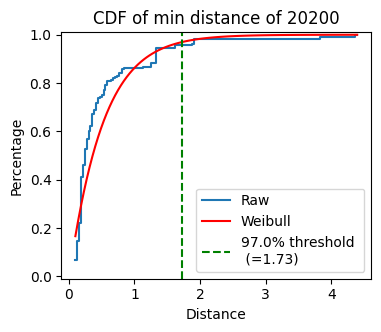

Value when CDF = 0.97: 2.11245060743406


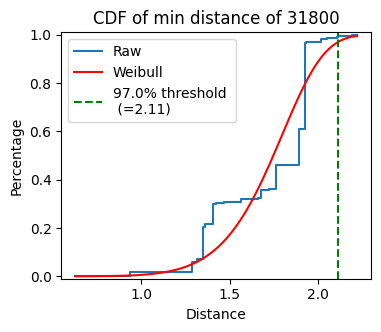

Value when CDF = 0.97: 0.8579228681585701


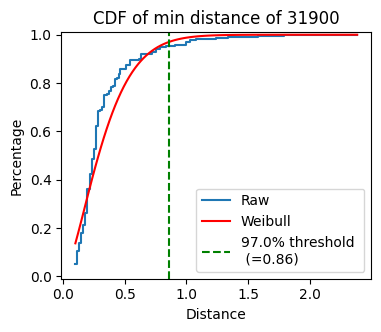

Value when CDF = 0.97: 1.857224763387656


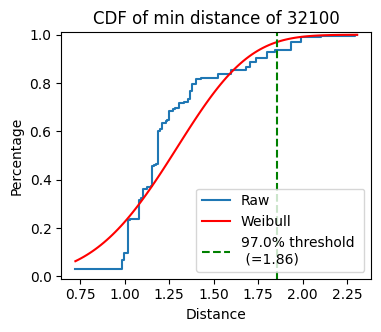

Value when CDF = 0.97: 39.40280932638193


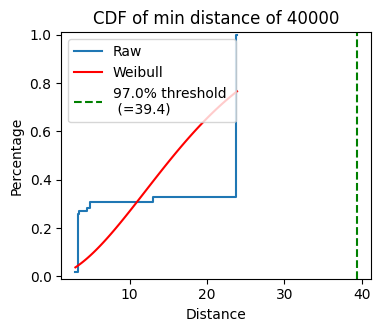

Value when CDF = 0.97: 4.5521579442883855


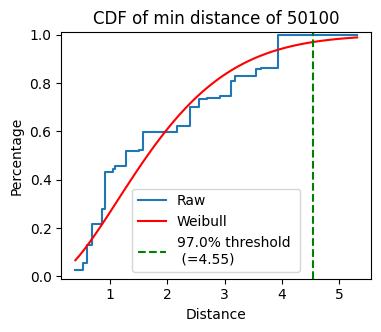

Value when CDF = 0.97: 8.867358943382756


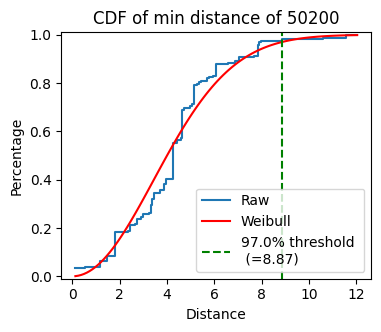

Value when CDF = 0.97: 15.235089649767442


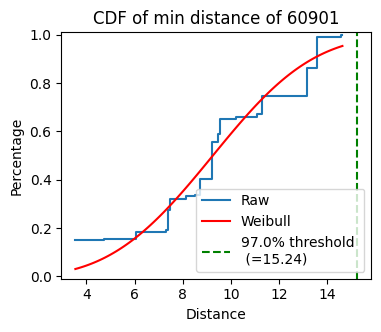

Value when CDF = 0.97: 7.007682458738564


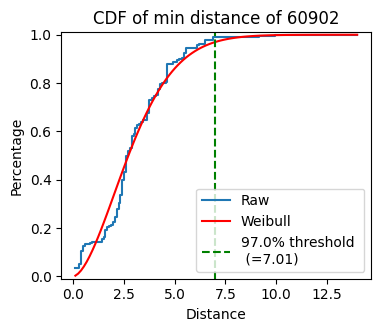

Value when CDF = 0.97: 6.519466292943238


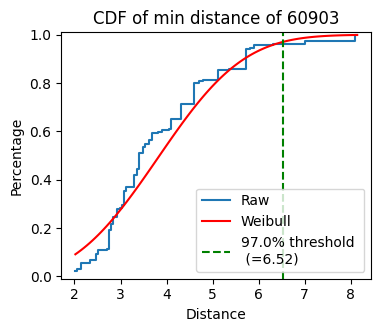

Value when CDF = 0.97: 12.930085529854408


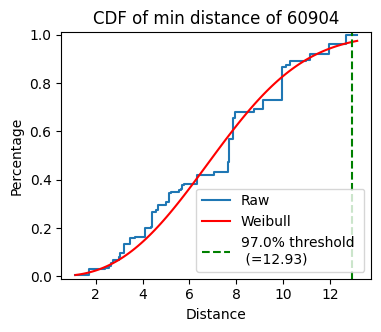

Value when CDF = 0.97: 13.72826154473559


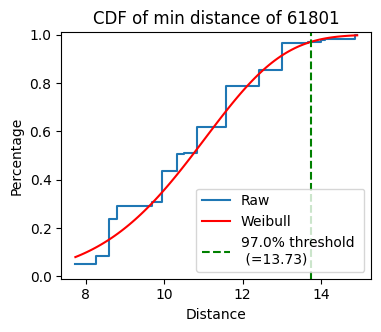

Value when CDF = 0.97: 13.061793428913399


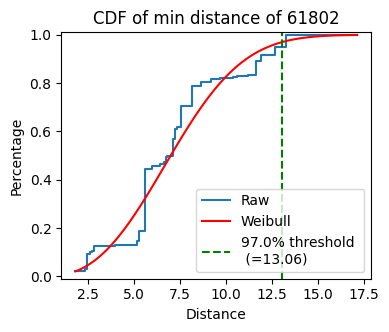

Value when CDF = 0.97: 12.014096650998209


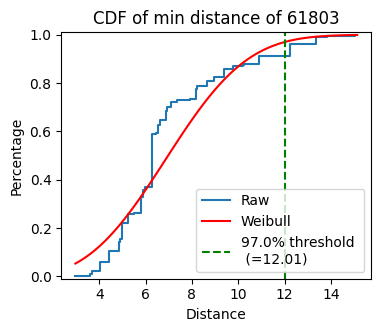

Value when CDF = 0.97: 8.432811187532218


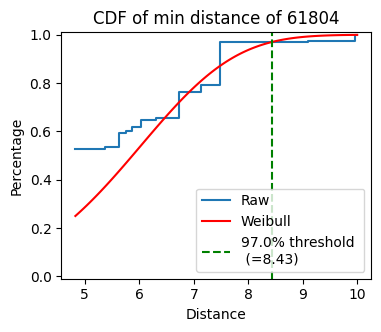

Value when CDF = 0.97: 11.425115069015407


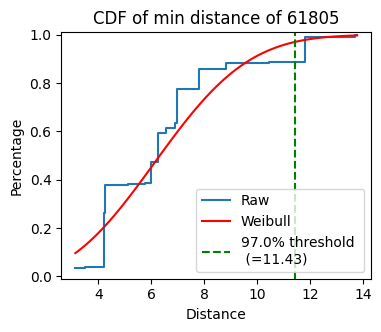

Value when CDF = 0.97: 8.625256312485755


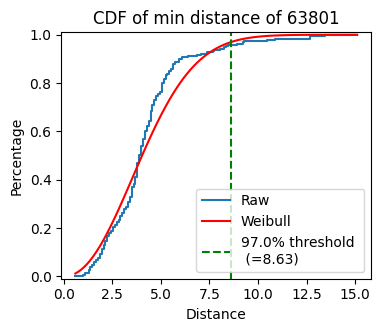

Value when CDF = 0.97: 9.461724900414474


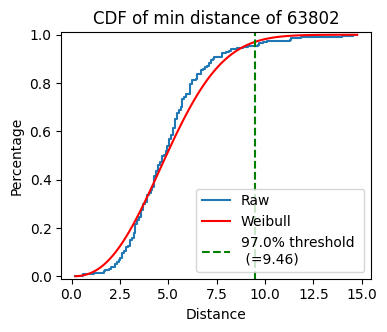

Value when CDF = 0.97: 13.080002992790375


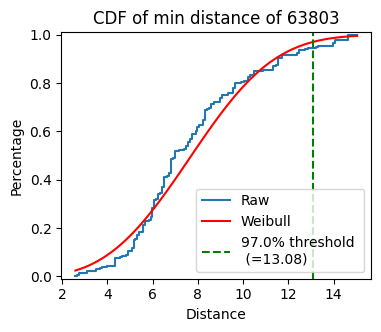

In [19]:
labels = np.unique(y_updated)
dist_thresholds = []

for label in labels[3:]:
    
    min_values = calculate_distance_threshold(dist_matrix,label)
    
    dist_threshold = fit_datapoints_weibull(
        min_values, Weight[y_updated==label],threshold = 0.97,
        fig = True,
        title = f"CDF of min distance of {label}"
    )
    dist_thresholds.append(dist_threshold)

Value when CDF = 0.97: 3.9421646154811114


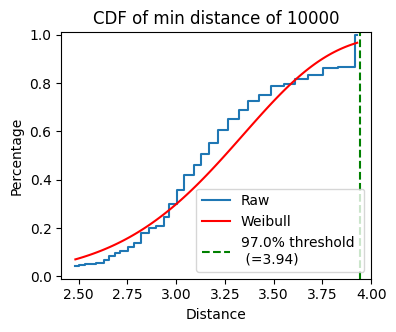

In [20]:
label = labels[1] # Cluster 10000

min_values = calculate_distance_threshold(dist_matrix,label)

dist_threshold = fit_datapoints_weibull(
    min_values, Weight[y_updated==label],threshold = 0.97,
    fig = True,
    title = f"CDF of min distance of {label}"
)

In [21]:
## add distance threshold for Cluster 10000
dist_thresholds.insert(0, dist_threshold)

## add distance threshold for Cluster 20100
dist_thresholds.insert(1, 1e-3)

In [24]:
print(dist_thresholds)
dist_thresholds = np.array(dist_thresholds)
np.save('.\\utils_data\\hc_dist_thres.npy', dist_thresholds)

[3.9421646154811114, 0.001, 1.7306968455201293, 2.11245060743406, 0.8579228681585701, 1.857224763387656, 39.40280932638193, 4.5521579442883855, 8.867358943382756, 15.235089649767442, 7.007682458738564, 6.519466292943238, 12.930085529854408, 13.72826154473559, 13.061793428913399, 12.014096650998209, 8.432811187532218, 11.425115069015407, 8.625256312485755, 9.461724900414474, 13.080002992790375]


In [188]:
# import numpy as np
# from scipy.optimize import minimize
# import matplotlib.pyplot as plt

# # Define the weighted negative log-likelihood function for the Weibull distribution
# def weibull_neg_log_likelihood(params, data, weights):
#     shape, scale = params
#     # Ensure shape and scale parameters are positive
#     if shape <= 0 or scale <= 0:
#         return np.inf
#     # Compute the log-likelihood
#     log_likelihood = (weights * (np.log(shape) - shape * np.log(scale) + (shape - 1) * np.log(data) - (data / scale) ** shape)).sum()
#     return -log_likelihood  # Negative because we will minimize

# # Example data points and their weights
# # data = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])
# data = min_values
# # weights = np.array([1, 2, 1, 1, 2, 1, 1])
# weights = Weight[y_updated==label]

# # Initial guesses for the shape and scale parameters
# initial_guess = [1.0, 1.0]

# # Minimize the negative log-likelihood function
# result = minimize(weibull_neg_log_likelihood, initial_guess, args=(data, weights), method='L-BFGS-B', bounds=[(0, None), (0, None)])

# # Extract the fitted shape and scale parameters
# shape, scale = result.x

# print(f"Fitted Shape: {shape}, Fitted Scale: {scale}")

# # Generate values from the fitted distribution
# x = np.linspace(min(data), max(data), 100)
# # x = np.linspace(0, max(data), 100)
# fitted_pdf = (shape / scale) * (x / scale) ** (shape - 1) * np.exp(-(x / scale) ** shape)
# fitted_cdf = 1 - np.exp(-(x / scale) ** shape)

# # Plot the histogram of the data and the fitted PDF
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.hist(data, bins=20, density=True, alpha=0.6, color='g', weights=weights, label='Weighted Data')
# plt.plot(x, fitted_pdf, 'r-', lw=2, label='Fitted Weibull PDF')
# plt.xlabel('Data')
# plt.ylabel('Density')
# plt.title('PDF')
# plt.legend()

# # Plot the CDF
# plt.subplot(1, 2, 2)
# plt.plot(x, fitted_cdf, 'r-', lw=2, label='Fitted Weibull CDF')
# plt.xlabel('Data')
# plt.ylabel('Cumulative Probability')
# plt.title('CDF')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Create the Weibull distribution object with the fitted parameters
# weibull_dist = stats.weibull_min(shape, scale=scale)

# # Calculate the value when CDF = 0.97
# value_at_cdf_97 = weibull_dist.ppf(0.97)

# print(f"Value when CDF = 0.97: {value_at_cdf_97}")

In [189]:
# import numpy as np
# import scipy.stats as stats
# import scipy.optimize as optimize
# import matplotlib.pyplot as plt

# # Example data points and their corresponding weights
# # data_points = np.array([1.5, 2.3, 3.1, 4.7, 2.9, 3.6])  # Replace with your actual data points
# data_points = min_values
# # weights = np.array([2, 1, 3, 1, 2, 1])  # Replace with your actual weights
# weights = Weight[y_updated==label]

# # Define the negative log-likelihood function for the lognormal distribution
# def neg_log_likelihood(params, data, weights):
#     shape, loc, scale = params
#     # Calculate the log-probability density function for the lognormal distribution
#     log_pdf = stats.lognorm.logpdf(data, s=shape, loc=loc, scale=scale)
#     # Weighted negative log-likelihood
#     nll = -np.sum(weights * log_pdf)
#     return nll

# # Initial guesses for shape, loc, and scale
# initial_params = [1, 0, 1]

# # Optimize the parameters to minimize the negative log-likelihood
# result = optimize.minimize(neg_log_likelihood, initial_params, args=(data_points, weights), method='L-BFGS-B', bounds=[(0, None), (0, None), (0, None)])
# shape, loc, scale = result.x

# # Create an array of values for the x-axis (for plotting the PDF)
# x = np.linspace(min(data_points), max(data_points), 1000)

# # Calculate the PDF of the fitted lognormal distribution
# pdf_fitted = stats.lognorm.pdf(x, shape, loc, scale)

# # Plot the histogram of the weighted data and the PDF of the fitted distribution
# plt.hist(data_points, bins=30, weights=weights, density=True, alpha=0.6, color='g', label='Weighted data histogram')
# plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted lognormal PDF')
# plt.xlabel('Data')
# plt.ylabel('Density')
# plt.legend()
# plt.show()

# # Print the fitted parameters
# print(f"Fitted parameters: shape={shape}, loc={loc}, scale={scale}")


# Cluster Visual Check

First Clustering

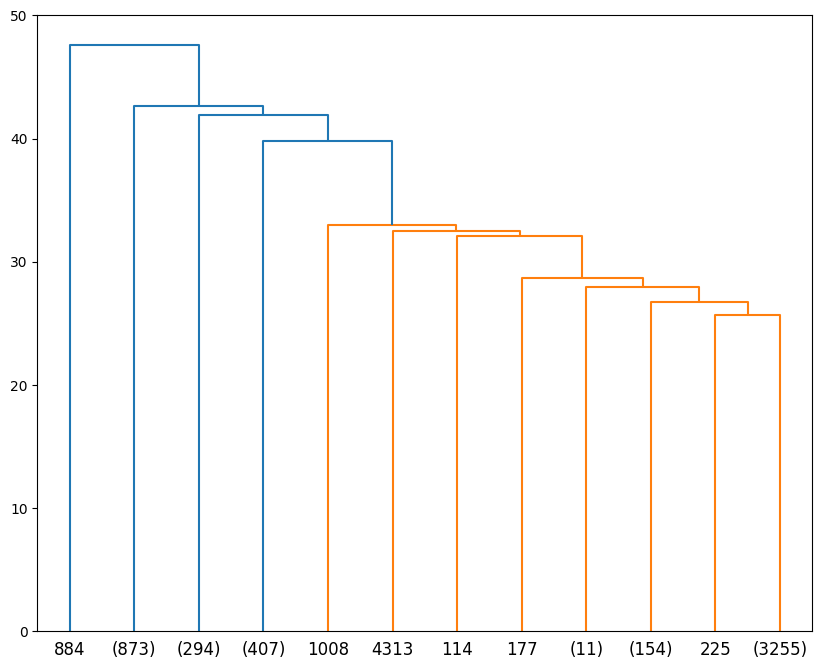

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([   6,  873,  294,  407,   11,  154, 3255], dtype=int64))

In [22]:
n_clusters = 12
# y = hc_fcluster(dist_matrix, method='single', n_cls=n_clusters, figsize=None)
y = hc_fcluster(dist_matrix, method='single', n_cls=n_clusters, figsize=(10,8))
y = filterOutlier(y)
np.unique(y,return_counts=True)

In [23]:
# mergeOutlierToOther(dist_matrix,y,y_target=0)
# np.unique(y,return_counts=True)

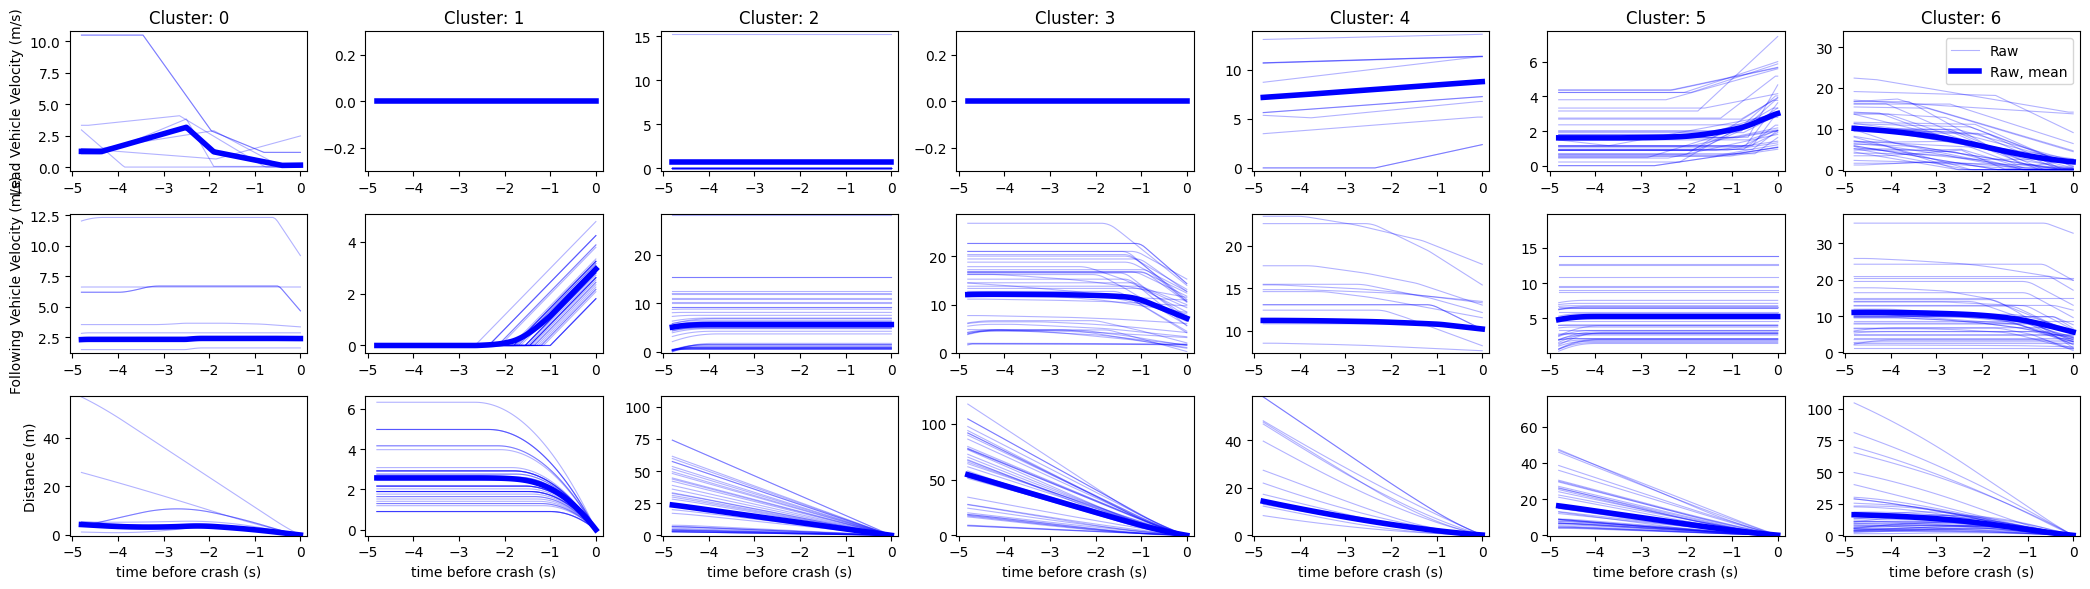

In [24]:
clsInspection(
    X,
    y,
    Weight,
    dimen=3,
#     cluster_selection = list(np.unique(y)[1:]),
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=2

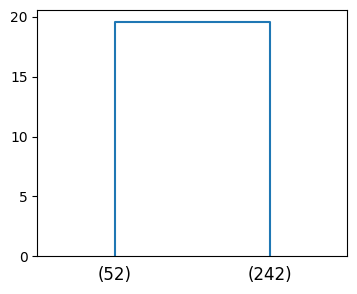

In [25]:
y_target = 2
dm_squareform = squareform(dist_matrix)
dm_sec = dm_squareform[y==y_target][:,y==y_target]
dm_sec = squareform(dm_sec)
y_sec = hc_fcluster(dm_sec, method='single', n_cls=2, figsize=(4, 3.2))
# y_sec_filter = filterOutlier(y_sec,threshold=10)

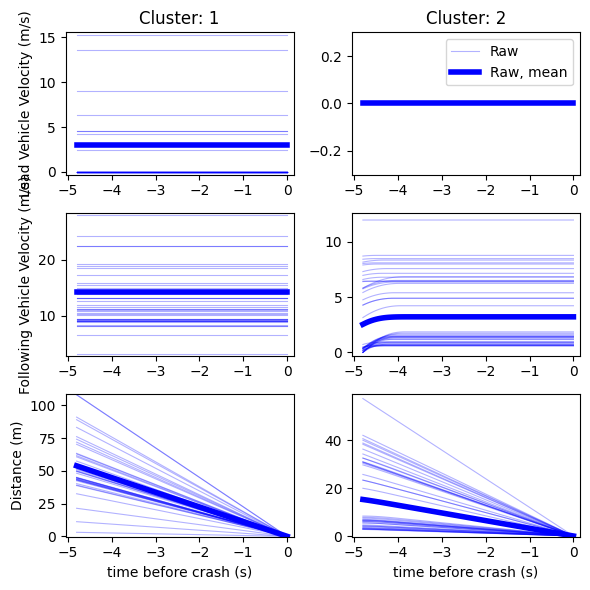

In [26]:
clsInspection(
    X[y==y_target],
    y_sec,
    Weight[y==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=3

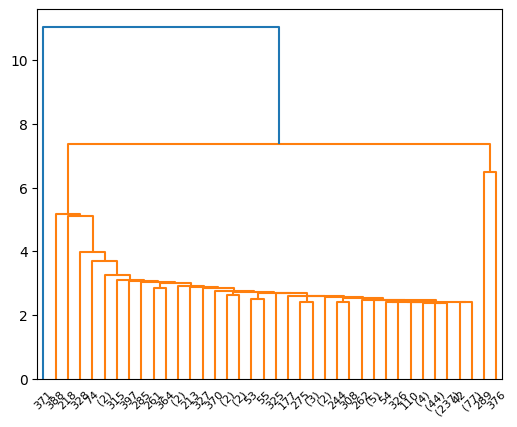

(array([ 0, 18, 19, 21], dtype=int32),
 array([ 49,  44, 237,  77], dtype=int64))

In [27]:
y_target = 3
dm_squareform = squareform(dist_matrix)
dm_sec = dm_squareform[y==y_target][:,y==y_target]
dm_sec = squareform(dm_sec)
# y_sec = hc_fcluster(dm_sec, method='complete', n_cls=3, figsize=(4, 3.2))
y_sec = hc_fcluster(dm_sec, method='single', n_cls=38, figsize=(6,4.8))
y_sec = filterOutlier(y_sec,threshold=10)
np.unique(y_sec,return_counts=True)

In [28]:
# mergeOutlierToOther(dm_sec,y_sec,y_target=1)
# np.unique(y_sec,return_counts=True)

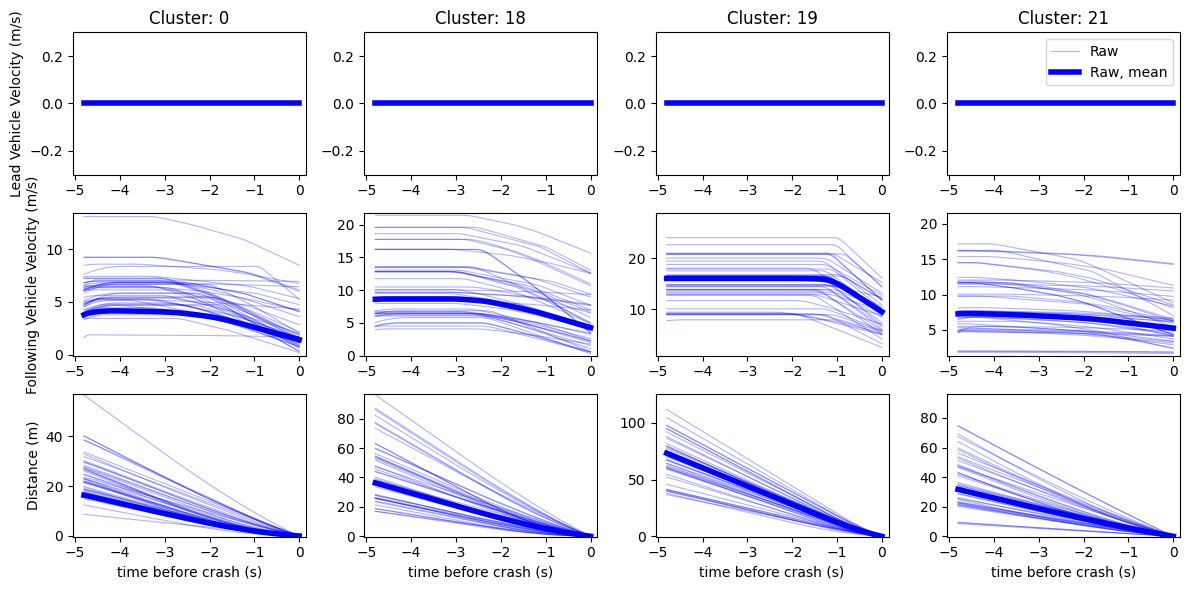

In [29]:
# y_target = 3
# dm_squareform = squareform(dist_matrix)
# dm_sec = dm_squareform[y==y_target][:,y==y_target]
# dm_sec = squareform(dm_sec)
# y_sec = hc_fcluster(dm_sec, method='complete', n_cls=3, figsize=(4, 3.2))
# # y_sec_filter = filterOutlier(y_sec,threshold=10)
clsInspection(
    X[y==y_target],
    y_sec,
    Weight[y==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

In [30]:
# y_sec[y_sec==3] = 1
# clsInspection(
#     X[y==y_target],
#     y_sec,
#     Weight[y==y_target],
#     dimen=3,
#     # cluster_selection = list(np.unique(y_sec)[1:]),
#     cluster_selection = None,
#     traj_number = 40,
#     line_transparency = 0.3,
#     line_width = 0.8,
#     line_width_ratio = 5,
#     fig_name=None)

Second Clustering y=5

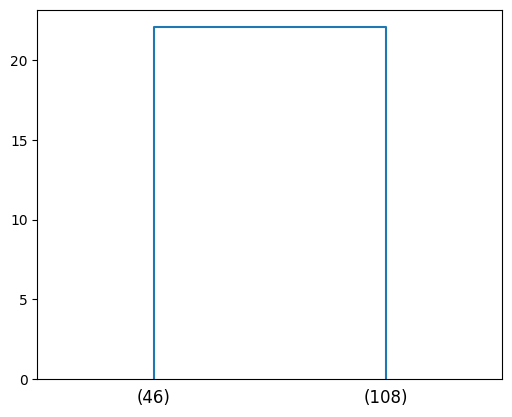

(array([1, 2], dtype=int32), array([ 46, 108], dtype=int64))

In [31]:
# y_target = 5
y_target = 5
dm_squareform = squareform(dist_matrix)
dm_sec = dm_squareform[y==y_target][:,y==y_target]
dm_sec = squareform(dm_sec)
y_sec = hc_fcluster(dm_sec, method='single', n_cls=2, figsize=(6, 4.8))
y_sec = filterOutlier(y_sec,threshold=10)
np.unique(y_sec,return_counts=True)

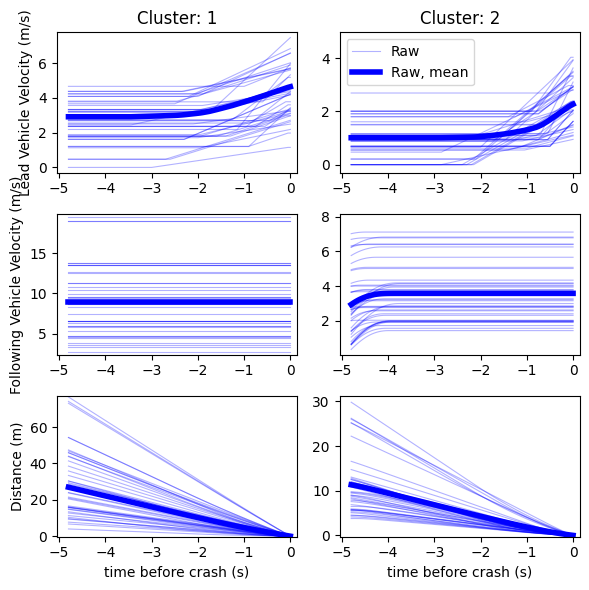

In [32]:
y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target],
    y_sec,
    Weight[y==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6

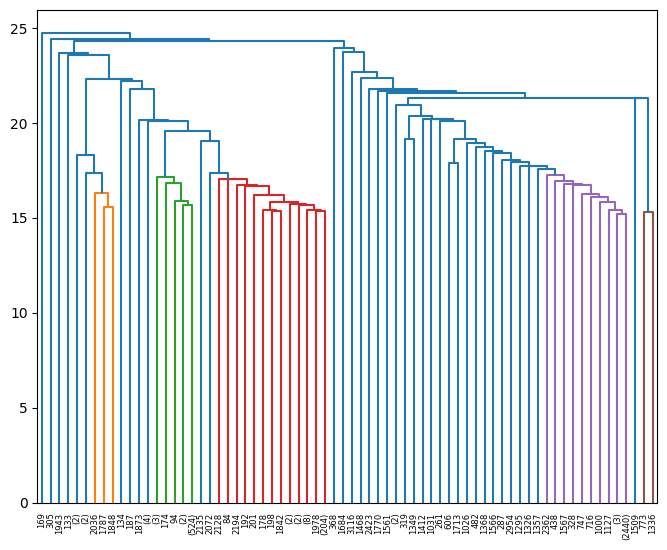

(array([ 0,  9, 18, 38], dtype=int32),
 array([  87,  524,  204, 2440], dtype=int64))

In [33]:
y_target = 6
dm_squareform = squareform(dist_matrix)
dm_sec = dm_squareform[y==y_target][:,y==y_target]
dm_sec = squareform(dm_sec)
# y_sec = hc_fcluster(dm_sec, method='single', n_cls=164, figsize=(8, 6.4))
y_sec = hc_fcluster(dm_sec, method='single', n_cls=70, figsize=(8, 6.4))
y_sec = filterOutlier(y_sec,threshold=10)
np.unique(y_sec,return_counts=True)

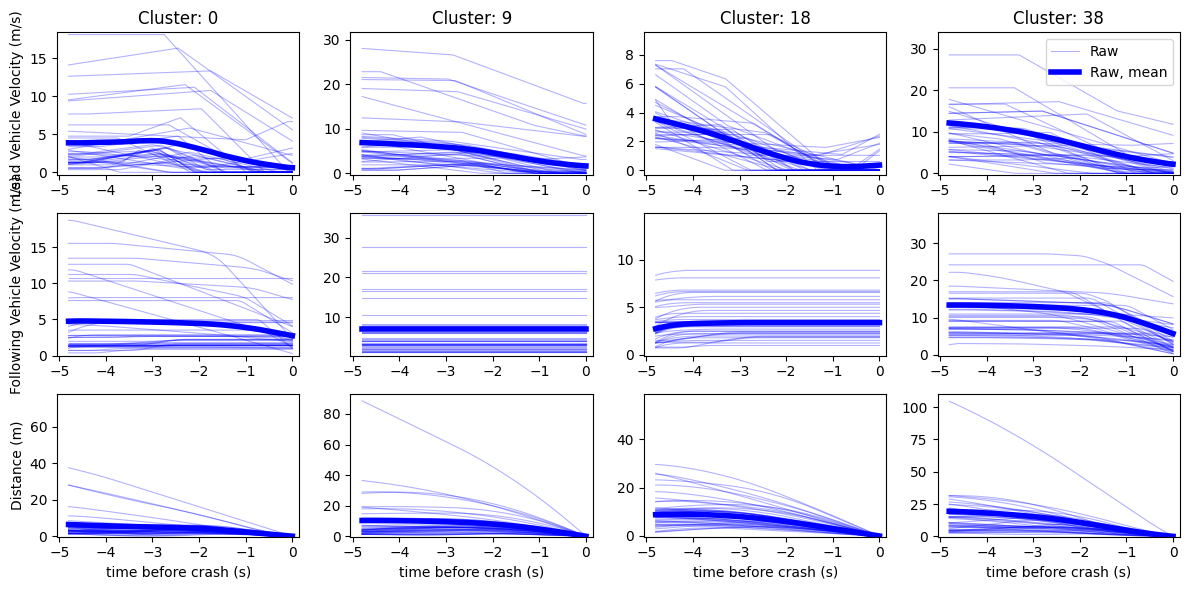

In [34]:
y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target],
    y_sec,
    Weight[y==y_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.9

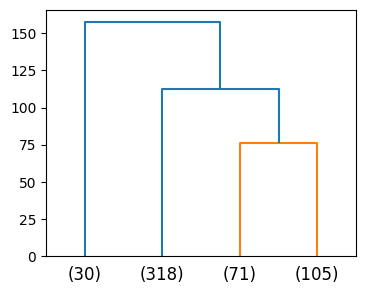

In [35]:
y_target = 6
y_sec_target = 9
dm_squareform = squareform(dist_matrix)
dm_sec_sec = dm_squareform[y==y_target][:,y==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target]
dm_sec_sec = squareform(dm_sec_sec)
y_sec_sec = hc_fcluster(dm_sec_sec, method='complete', n_cls=4, figsize=(4, 3.2))

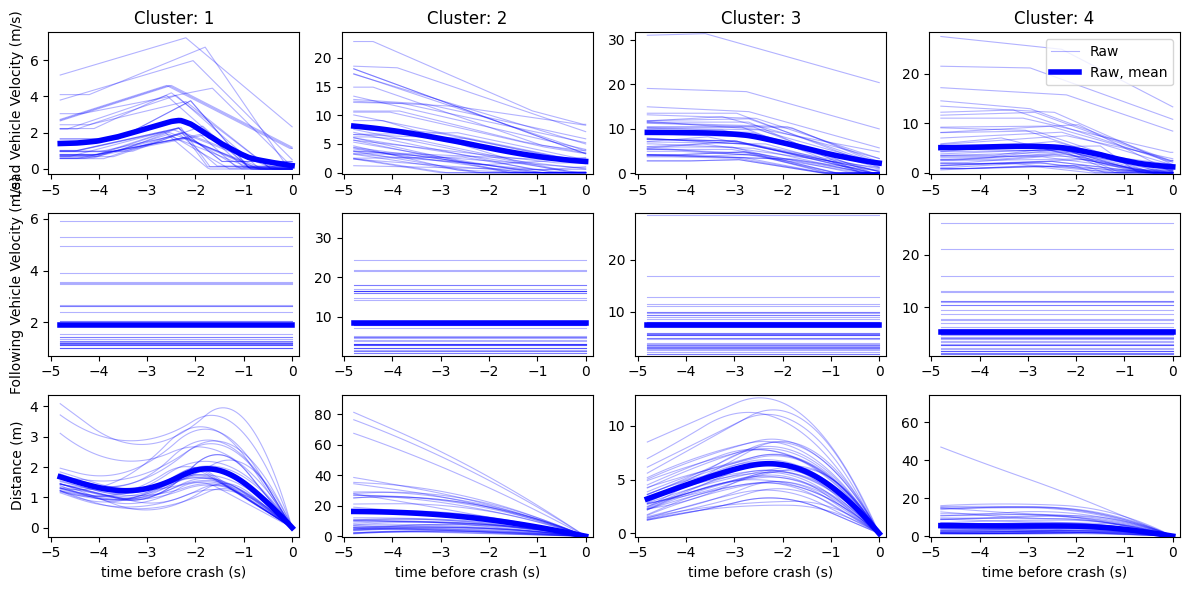

In [36]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target][y_sec==y_sec_target],
    y_sec_sec,
    Weight[y==y_target][y_sec==y_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.18

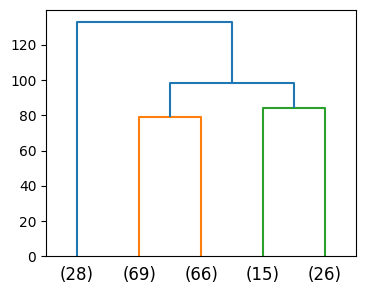

In [37]:
y_target = 6
y_sec_target = 18
dm_squareform = squareform(dist_matrix)
dm_sec_sec = dm_squareform[y==y_target][:,y==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target]
dm_sec_sec = squareform(dm_sec_sec)
y_sec_sec = hc_fcluster(dm_sec_sec, method='complete', n_cls=5, figsize=(4, 3.2))

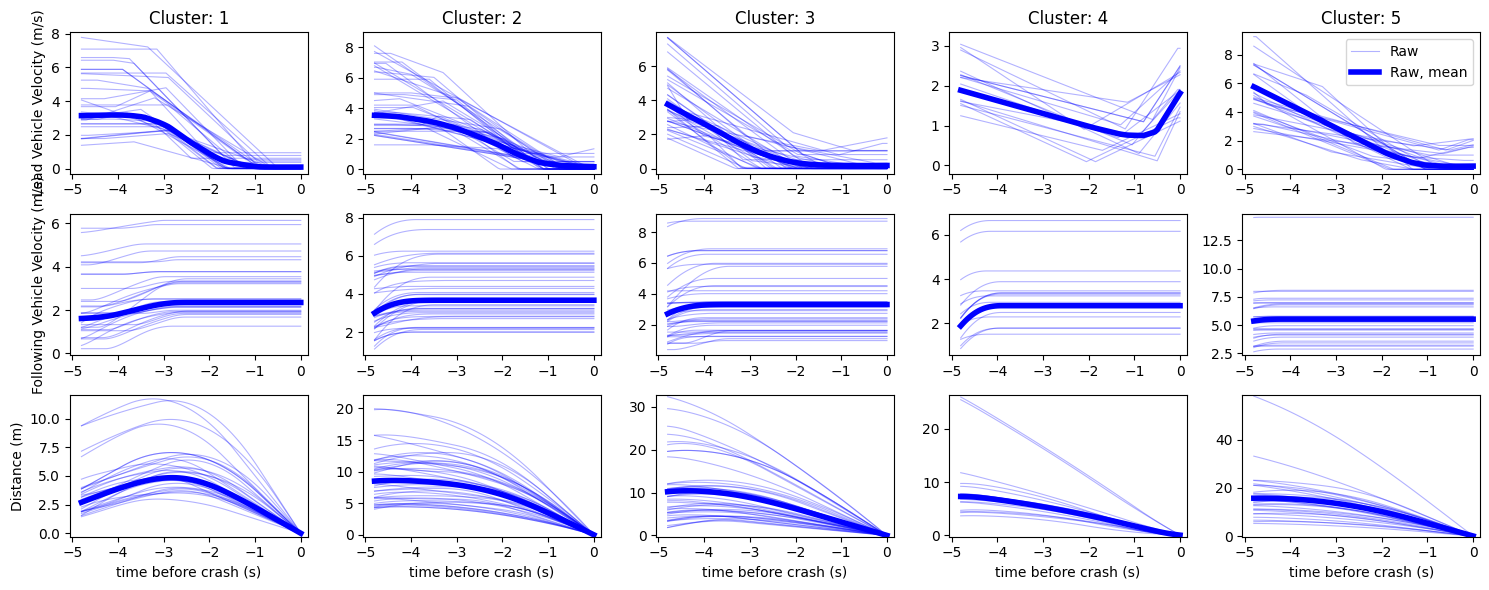

In [38]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target][y_sec==y_sec_target],
    y_sec_sec,
    Weight[y==y_target][y_sec==y_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)

Second Clustering y=6.38

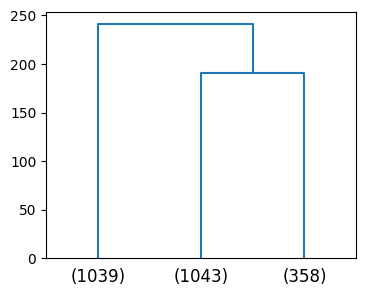

In [39]:
y_target = 6
y_sec_target = 38
dm_squareform = squareform(dist_matrix)
dm_sec_sec = dm_squareform[y==y_target][:,y==y_target][y_sec==y_sec_target][:,y_sec==y_sec_target]
dm_sec_sec = squareform(dm_sec_sec)
y_sec_sec = hc_fcluster(dm_sec_sec, method='complete', n_cls=3, figsize=(4, 3.2))
# y_sec_sec = hc_fcluster(dm_sec_sec, method='single', n_cls=1000, figsize=(10, 8))
# y_sec_sec = filterOutlier(y_sec_sec,threshold=10)
# np.unique(y_sec_sec,return_counts=True)

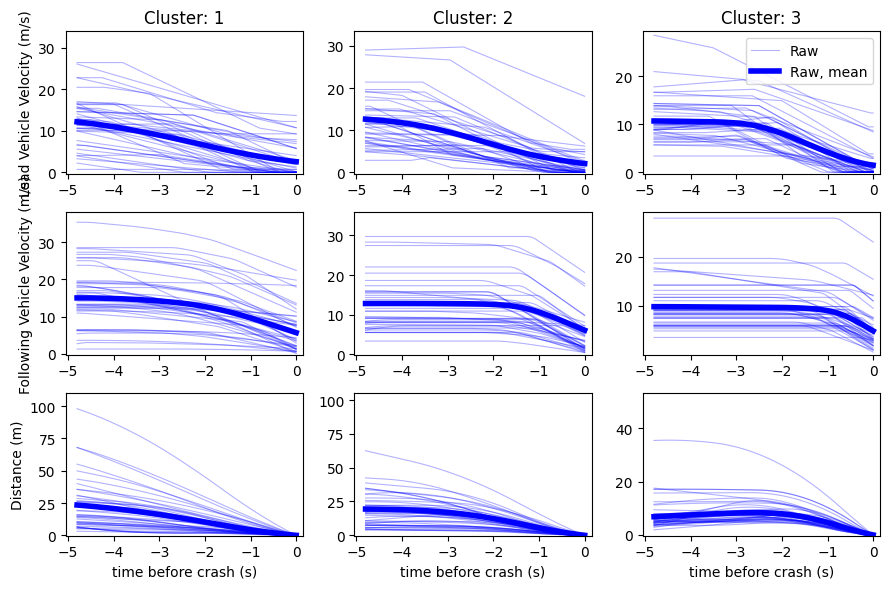

In [40]:
# y_sec = filterOutlier(y_sec,threshold=5)
clsInspection(
    X[y==y_target][y_sec==y_sec_target],
    y_sec_sec,
    Weight[y==y_target][y_sec==y_sec_target],
    dimen=3,
    # cluster_selection = list(np.unique(y_sec)[1:]),
    cluster_selection = None,
    traj_number = 40,
    line_transparency = 0.3,
    line_width = 0.8,
    line_width_ratio = 5,
    fig_name=None)